In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, stddev, corr, ntile
from pyspark.sql.window import Window

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

%matplotlib inline

spark = SparkSession.builder \
    .appName("EmployeeSalariesLab") \
    .master("local[*]") \
    .getOrCreate()

In [19]:
import pandas as pd

data_path = "Employee_Salaries_-_2023.csv"

# Чтение CSV без попытки разделить по пробелам
raw_df = pd.read_csv(
    data_path,
    header=None,
    engine="python"
)

# Переименование колонок
feature_names = [
    "Department", "Department_Name", "Division", "Gender",
    "Base_Salary", "Overtime_Pay", "Longevity_Pay", "Grade"
]
raw_df.columns = feature_names

# Добавим целевую переменную (если нужно, например Base_Salary)
raw_df["MEDV"] = raw_df["Base_Salary"]

# Проверка
raw_df.info()
raw_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10292 entries, 0 to 10291
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Department       10292 non-null  object
 1   Department_Name  10292 non-null  object
 2   Division         10292 non-null  object
 3   Gender           10292 non-null  object
 4   Base_Salary      10292 non-null  object
 5   Overtime_Pay     10292 non-null  object
 6   Longevity_Pay    10292 non-null  object
 7   Grade            10259 non-null  object
 8   MEDV             10292 non-null  object
dtypes: object(9)
memory usage: 723.8+ KB


,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Grade,MEDV
0,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Grade,Base_Salary
1,ABS,Alcohol Beverage Services,ABS 85 Administration,M,175873,0,0,M2,175873
2,ABS,Alcohol Beverage Services,ABS 85 Administration,M,145613.36,0,0,M3,145613.36
3,ABS,Alcohol Beverage Services,ABS 85 Administration,F,136970,0,0,M3,136970
4,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,89432.694,0,2490,21,89432.694


In [35]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

schema = StructType([
    StructField("Department",      StringType(), True),
    StructField("Department_Name", StringType(), True),
    StructField("Division",        StringType(), True),
    StructField("Gender",          StringType(), True),
    StructField("Base_Salary",     DoubleType(), True),
    StructField("Overtime_Pay",    DoubleType(), True),
    StructField("Longevity_Pay",   DoubleType(), True),
    StructField("Grade",           StringType(), True),
    StructField("MEDV",            DoubleType(), True),
])

Employee_sdf = spark.createDataFrame(boston_pd, schema=schema)
Employee_sdf.createOrReplaceTempView("Employee")

Employee_sdf.printSchema()
print("Количество строк:", Employee_sdf.count())

Employee_sdf.describe().show()

root
 |-- Department: string (nullable = true)
 |-- Department_Name: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Base_Salary: double (nullable = true)
 |-- Overtime_Pay: double (nullable = true)
 |-- Longevity_Pay: double (nullable = true)
 |-- Grade: string (nullable = true)
 |-- MEDV: double (nullable = true)

Количество строк: 506
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+
|summary|        Department|   Department_Name|          Division|            Gender|        Base_Salary|      Overtime_Pay|     Longevity_Pay|             Grade|             MEDV|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+
|  count|               506|               506|          

+---+----------+----------+------------------+-------------------+
|  n|min_salary|max_salary|        avg_salary|         std_salary|
+---+----------+----------+------------------+-------------------+
|506|     0.385|     0.871|0.5546950592885382|0.11587767566755594|
+---+----------+----------+------------------+-------------------+



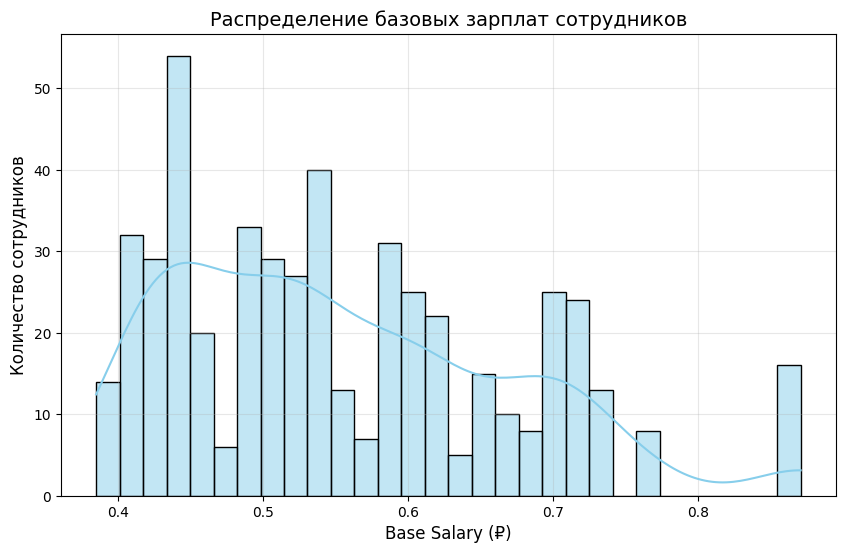

In [37]:
# SQL-запрос для расчета основных статистик
salary_stats = spark.sql("""
    SELECT
        COUNT(*)        AS n,
        MIN(Base_Salary) AS min_salary,
        MAX(Base_Salary) AS max_salary,
        AVG(Base_Salary) AS avg_salary,
        STDDEV(Base_Salary) AS std_salary
    FROM Employee
""")
salary_stats.show()

# Конвертируем столбец Base_Salary в Pandas для построения графика
salaries_pd = Employee_sdf.select("Base_Salary").toPandas()

# Построение гистограммы распределения базовых зарплат
plt.figure(figsize=(10, 6))
sns.histplot(salaries_pd["Base_Salary"], bins=30, kde=True, color="skyblue", edgecolor="black")
plt.xlabel("Base Salary (₽)", fontsize=12)
plt.ylabel("Количество сотрудников", fontsize=12)
plt.title("Распределение базовых зарплат сотрудников", fontsize=14)
plt.grid(alpha=0.3)
plt.show()


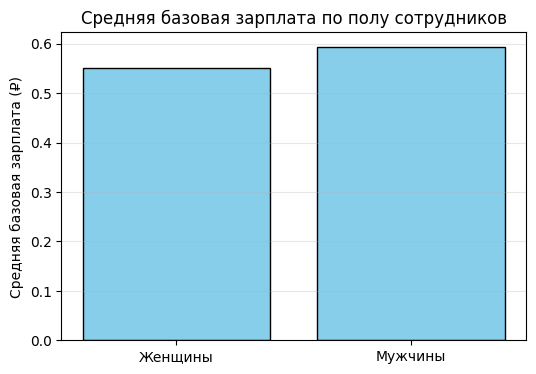

In [42]:
# Получаем статистику по полу
gender_stats = spark.sql("""
    SELECT
        Gender,
        COUNT(*) AS cnt,
        AVG(Base_Salary) AS avg_salary,
        MIN(Base_Salary) AS min_salary,
        MAX(Base_Salary) AS max_salary
    FROM Employee
    GROUP BY Gender
    ORDER BY Gender
""")

# Преобразуем в Pandas
gender_pd = gender_stats.toPandas()

# Преобразуем строки к float, затем к int
gender_pd["Gender"] = gender_pd["Gender"].astype(float).astype(int)

# Создаем метки
gender_pd["Gender_label"] = gender_pd["Gender"].map({0: "Женщины", 1: "Мужчины"})

# Строим столбчатую диаграмму
plt.figure(figsize=(6, 4))
plt.bar(gender_pd["Gender_label"], gender_pd["avg_salary"], color="skyblue", edgecolor="black")
plt.ylabel("Средняя базовая зарплата (₽)")
plt.title("Средняя базовая зарплата по полу сотрудников")
plt.grid(axis="y", alpha=0.3)
plt.show()


Корреляция между Base_Salary и Overtime_Pay: -0.3021881878495937


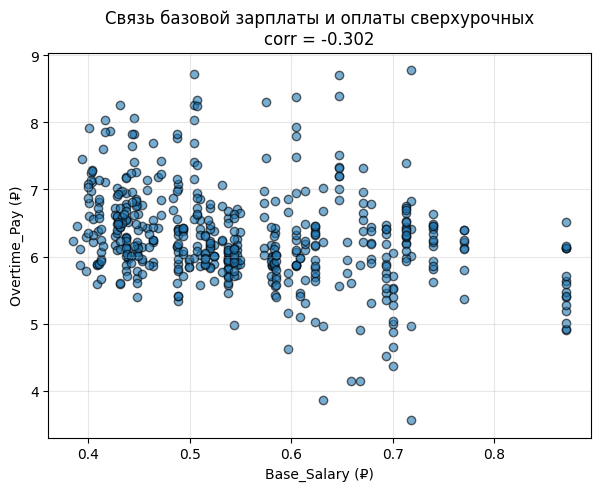

In [43]:
# Корреляция между Base_Salary и Overtime_Pay
corr_salary_ot = Employee_sdf.stat.corr("Base_Salary", "Overtime_Pay")
print("Корреляция между Base_Salary и Overtime_Pay:", corr_salary_ot)

# Выбираем нужные колонки для визуализации
salary_ot_sdf = spark.sql("""
    SELECT Base_Salary, Overtime_Pay
    FROM Employee
    WHERE Base_Salary IS NOT NULL AND Overtime_Pay IS NOT NULL
""")
salary_ot_pd = salary_ot_sdf.toPandas()

# Построение scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(salary_ot_pd["Base_Salary"], salary_ot_pd["Overtime_Pay"], alpha=0.6, edgecolor="black")
plt.xlabel("Base_Salary (₽)")
plt.ylabel("Overtime_Pay (₽)")
plt.title(f"Связь базовой зарплаты и оплаты сверхурочных\ncorr = {corr_salary_ot:.3f}")
plt.grid(alpha=0.3)
plt.show()


+---------------+---+-------------------+-----------------+
|salary_quartile|cnt|    avg_base_salary|     avg_overtime|
+---------------+---+-------------------+-----------------+
|              1|127| 0.4259503937007873|6.561314960629922|
|              2|127|0.49687401574803125|6.420275590551181|
|              3|126| 0.5787936507936503|6.105365079365076|
|              4|126| 0.7186428571428564| 6.04830952380952|
+---------------+---+-------------------+-----------------+



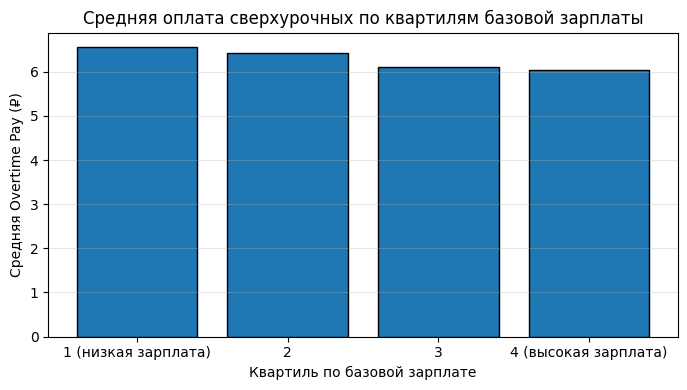

In [46]:
from pyspark.sql.window import Window
from pyspark.sql.functions import ntile, col, avg, count

# Создаем окно для квартилей по Base_Salary
window_spec = Window.orderBy(col("Base_Salary"))

employee_quartiles_sdf = Employee_sdf.withColumn("salary_quartile", ntile(4).over(window_spec))

# Агрегируем данные по квартилям
quartile_stats_sdf = employee_quartiles_sdf.groupBy("salary_quartile").agg(
    count("*").alias("cnt"),
    avg("Base_Salary").alias("avg_base_salary"),
    avg("Overtime_Pay").alias("avg_overtime")
).orderBy("salary_quartile")

quartile_stats_sdf.show()

# Для графика
quartile_stats_pd = quartile_stats_sdf.toPandas()
quartile_stats_pd["quartile_label"] = quartile_stats_pd["salary_quartile"].map({
    1: "1 (низкая зарплата)",
    2: "2",
    3: "3",
    4: "4 (высокая зарплата)"
})

plt.figure(figsize=(7, 4))
plt.bar(quartile_stats_pd["quartile_label"], quartile_stats_pd["avg_overtime"], edgecolor="black")
plt.xlabel("Квартиль по базовой зарплате")
plt.ylabel("Средняя Overtime Pay (₽)")
plt.title("Средняя оплата сверхурочных по квартилям базовой зарплаты")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


+------------------+------------------+------------------+---+
|longevity_quartile|     avg_longevity|   avg_base_salary|cnt|
+------------------+------------------+------------------+---+
|                 1|27.641732283464567|0.4443133858267718|127|
|                 2| 61.93543307086613|0.5017314960629919|127|
|                 3| 87.26190476190472|0.6119047619047618|126|
|                 4|  97.8380952380952|0.6621269841269842|126|
+------------------+------------------+------------------+---+



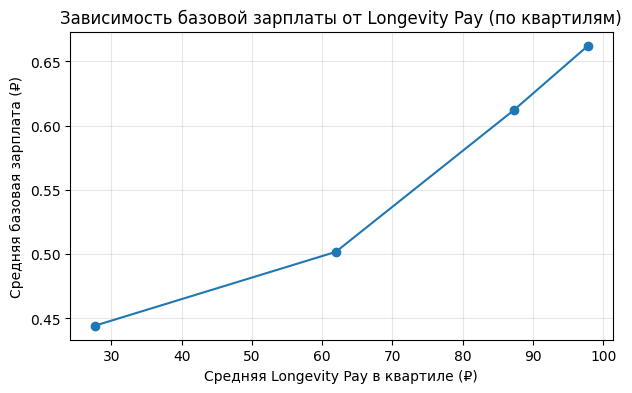

In [47]:
from pyspark.sql.window import Window
from pyspark.sql.functions import ntile, avg, col

# Создаем окно для квартилей по Longevity_Pay
window_spec = Window.orderBy(col("Longevity_Pay"))

longevity_quartiles_sdf = Employee_sdf.withColumn("longevity_quartile", ntile(4).over(window_spec))

# Агрегируем данные по квартилям
quartile_stats_sdf = longevity_quartiles_sdf.groupBy("longevity_quartile").agg(
    avg("Longevity_Pay").alias("avg_longevity"),
    avg("Base_Salary").alias("avg_base_salary"),
    count("*").alias("cnt")
).orderBy("longevity_quartile")

quartile_stats_sdf.show()

# Для графика
quartile_stats_pd = quartile_stats_sdf.toPandas()

plt.figure(figsize=(7, 4))
plt.plot(quartile_stats_pd["avg_longevity"], quartile_stats_pd["avg_base_salary"], marker="o")
plt.xlabel("Средняя Longevity Pay в квартиле (₽)")
plt.ylabel("Средняя базовая зарплата (₽)")
plt.title("Зависимость базовой зарплаты от Longevity Pay (по квартилям)")
plt.grid(alpha=0.3)
plt.show()
